Stock Forecasting - Data Import

In [13]:
import pandas as pd
import tensorflow_probability as tfp
from tensorflow_probability import sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import tensorflow as tf
import numpy as np

# Import data
stock_df = pd.read_csv(
    'spx.csv',
    names=["datetime","close"],
    dtype={'datetime':'str', 'close':'float'},
    parse_dates=['datetime'],
    header=0,
    skiprows = 0,
    na_values=['Null']
)

stock_df = stock_df.sort_values(by=['datetime'])
dates = stock_df['datetime']
close = stock_df['close']

# Take an arbritary slice of the data
start_date = '2000-01-1'
end_date = '2012-07-1'
middle_date = '2011-07-1'

# Slice data into training and testing sets
all_dates = (dates > start_date)&(dates < end_date)
training_dates = (dates > start_date)&(dates < middle_date)
testing_dates = (dates >= middle_date)&(dates < end_date)

training_data = close[training_dates]
all_data = close[all_dates]
dates_list = dates[all_dates]

ARIMA Model

/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you 

7791.458241500906


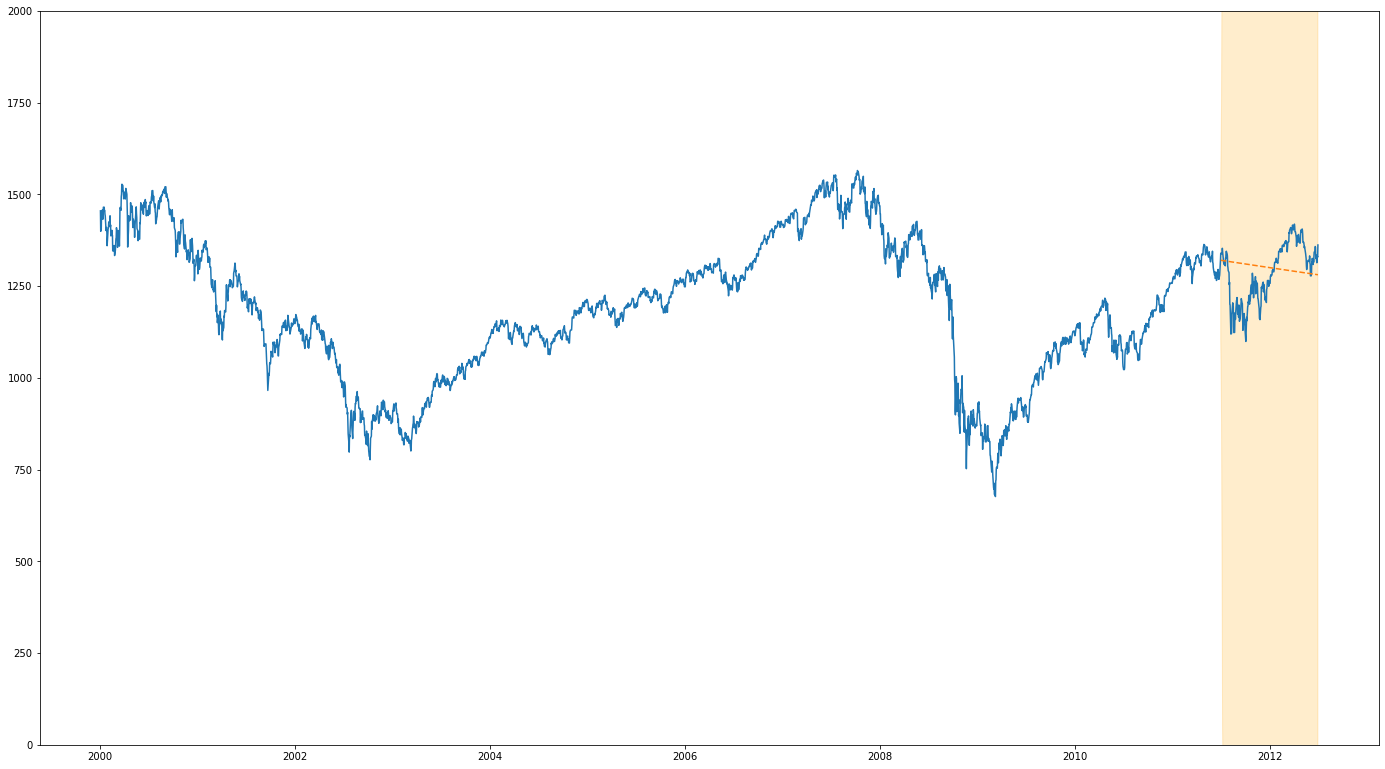

In [2]:
# Define ARIMA parameters
order = [1, 0, 0]
# Fit model - this may take some time
fit = SARIMAX(endog=training_data, order=order).fit()
# Create forecasts and score Model
ARIMA_forecast = fit.get_forecast(sum(testing_dates))
ARIMA_score = mean_squared_error(close[testing_dates].values, ARIMA_forecast.predicted_mean)
print(ARIMA_score)

# Plot Model
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.set_ylim(0, 2000)
ax.plot(
    dates[all_dates].values,
    close[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    ARIMA_forecast.predicted_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    ARIMA_forecast.predicted_mean-1*ARIMA_forecast.var_pred_mean,
    ARIMA_forecast.predicted_mean+1*ARIMA_forecast.var_pred_mean,
    color='Orange',
    alpha=0.2)
#fig.savefig('plots/ARIMA_stock_pred.png')
plt.show()

BSTS Model

/home/william-embecosm/.local/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


8556.164261856677


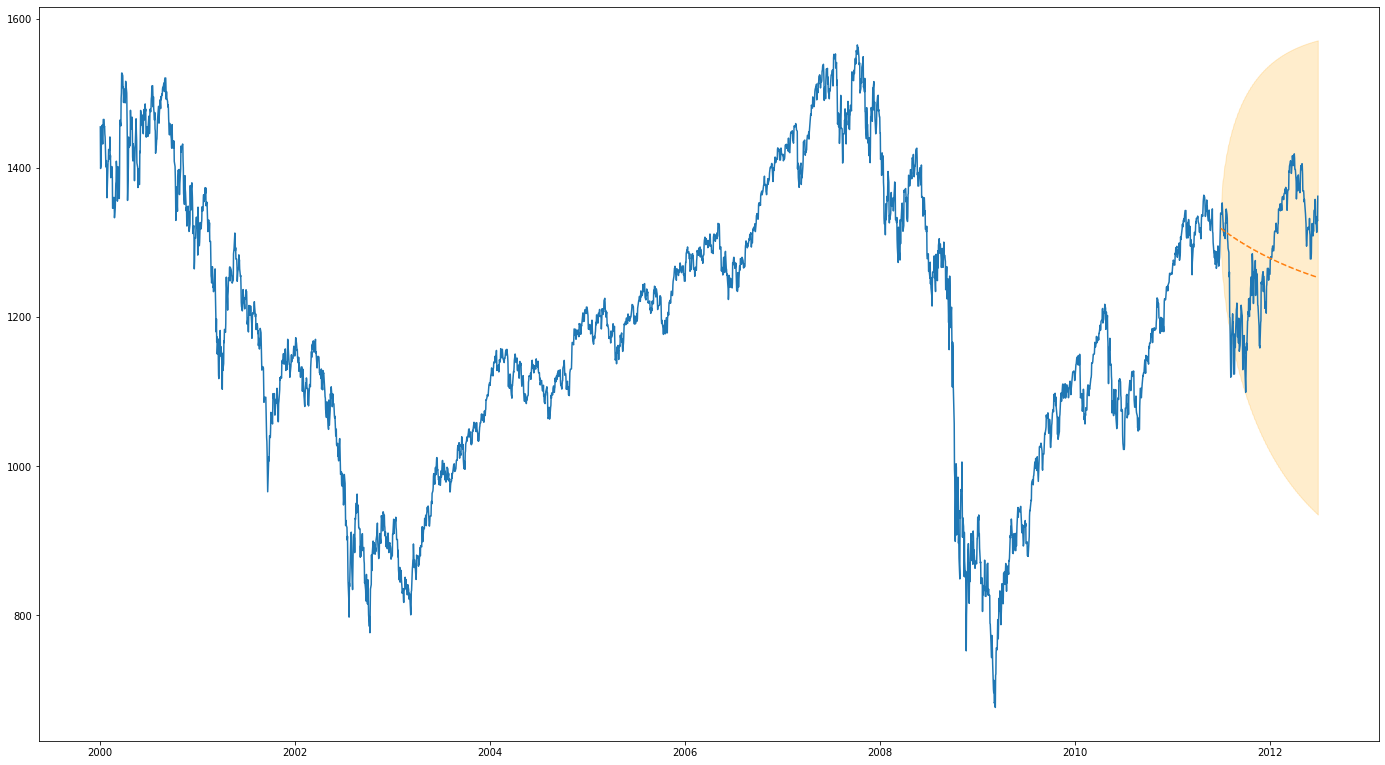

In [19]:
# Define Components of BSTS Model
# trend = tfp.sts.LocalLevel(
#   observed_time_series=training_data,
#   name = 'trend'
# )
trend = tfp.sts.Autoregressive(
  order = 1,
  observed_time_series=training_data,
  name = 'trend'
)
model = sts.Sum(
  components = [trend],
  observed_time_series=training_data
)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
# Fit Model. This may take some time. 
q_samples_demand_, kernel_results = tfp.sts.fit_with_hmc(
    model=model, observed_time_series=training_data.values)
# Create forecast and score model
findata_forecast_dist = tfp.sts.forecast(
    model = model,
    observed_time_series=training_data.values,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=sum(testing_dates))
num_samples=100
findata_forecast_mean, findata_forecast_scale, findata_forecast_samples = (
    findata_forecast_dist.mean().numpy()[..., 0],
    findata_forecast_dist.stddev().numpy()[..., 0],
    findata_forecast_dist.sample(num_samples).numpy()[..., 0])
BSTS_score = mean_squared_error(close[testing_dates].values, findata_forecast_mean)
print(BSTS_score)
# Plot data
findata_loc = mdates.YearLocator(3)
findata_fmt = mdates.DateFormatter('%M%Y')
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.plot(
    dates[all_dates].values,
    close[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    findata_forecast_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    findata_forecast_mean-2*findata_forecast_scale,
    findata_forecast_mean+2*findata_forecast_scale,
    color='Orange',
    alpha=0.2)
plt.show()

In [4]:
ftse_df = pd.read_csv(
    'ftse.csv',
    names=["datetime","close"],
    dtype={'datetime':'str', 'close':'float'},
    parse_dates=['datetime'],
    header=0,
    skiprows = 0,
    na_values=['Null']
)

ftse_df = ftse_df.sort_values(by=['datetime'])
regress_dates = ftse_df['datetime']
regress_close = ftse_df['close']

regress_all_dates = (regress_dates > start_date)&(regress_dates < end_date)
regress_training_dates = (regress_dates > start_date)&(regress_dates < middle_date)
regress_testing_dates = (regress_dates >= middle_date)&(regress_dates < end_date)

regress_training_data = regress_close[regress_training_dates]
regress_testing_data = regress_close[regress_testing_dates]
regress_all_data = regress_close[regress_all_dates]
regress_dates_list = regress_dates[regress_all_dates]

ARIMA with Regression

/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4919.661215533058


/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


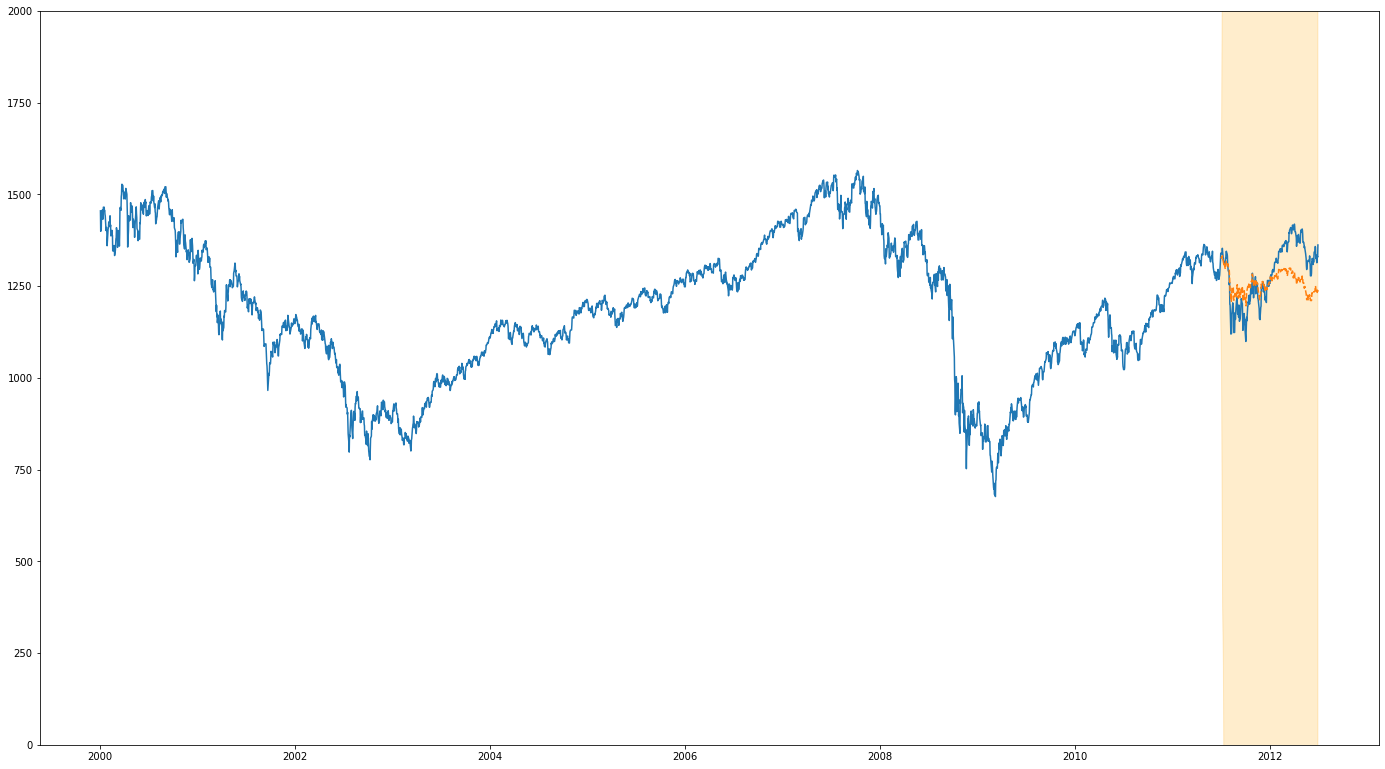

In [5]:
# Define ARIMA parameters
order = [1, 0, 0]
# Fit model - this may take some time

fit = SARIMAX(endog=training_data, exog=regress_training_data, order=order).fit()
# Create forecasts and score Model
ARIMA_forecast = fit.get_forecast(sum(testing_dates), exog=regress_testing_data)
ARIMA_score = mean_squared_error(close[testing_dates].values, ARIMA_forecast.predicted_mean)
print(ARIMA_score)

# Plot Model
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.set_ylim(0, 2000)
ax.plot(
    dates[all_dates].values,
    close[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    ARIMA_forecast.predicted_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    ARIMA_forecast.predicted_mean-1*ARIMA_forecast.var_pred_mean,
    ARIMA_forecast.predicted_mean+1*ARIMA_forecast.var_pred_mean,
    color='Orange',
    alpha=0.2)
#fig.savefig('plots/ARIMA_stock_pred.png')
plt.show()

/home/william-embecosm/.local/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


2151.9442788654137


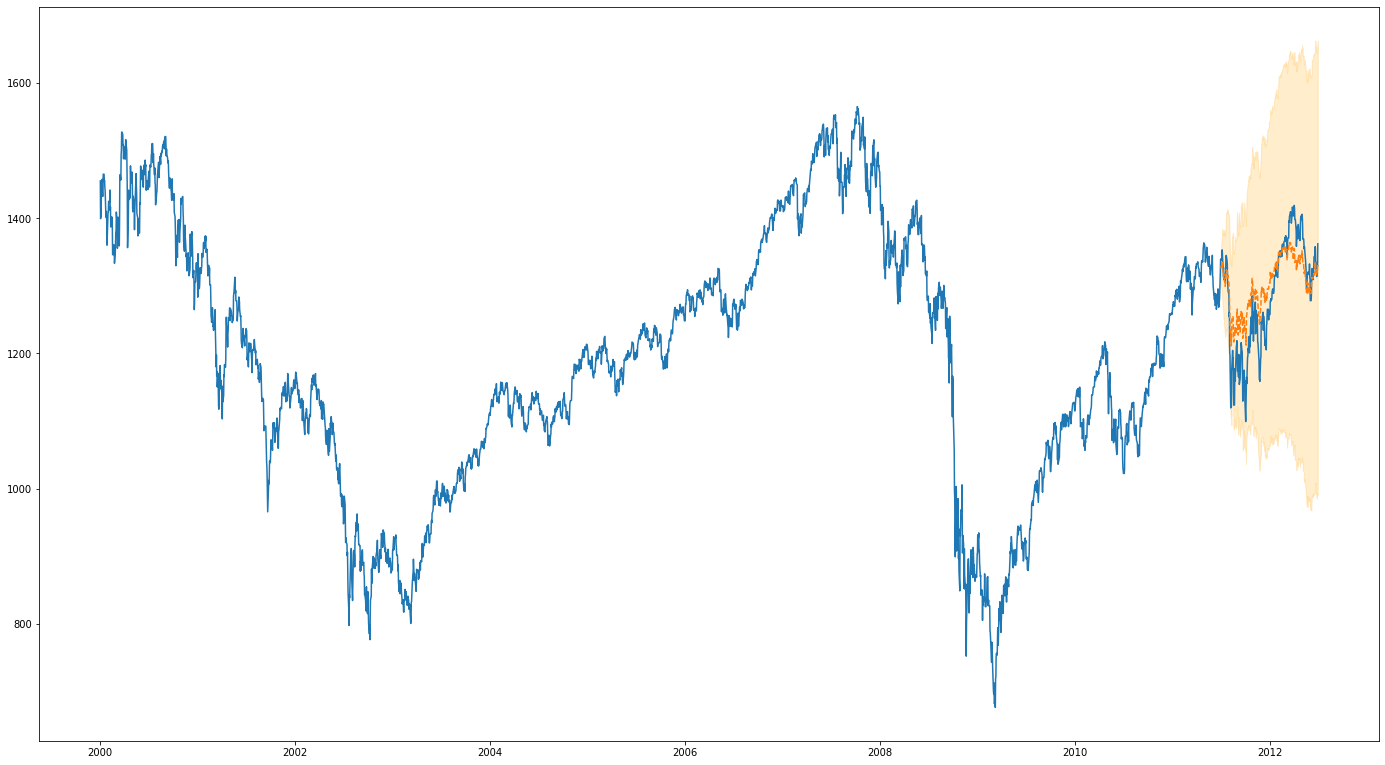

In [11]:
# Define Components of BSTS Model
# trend = tfp.sts.LocalLevel(
#   observed_time_series=training_data,
#   name = 'trend'
# )
design_matrix = tf.reshape(regress_all_data, (-1,1))
trend = tfp.sts.Autoregressive(
  order = 1,
  observed_time_series=training_data,
  name = 'trend'
)
regression = tfp.sts.LinearRegression(
      design_matrix=design_matrix
  )
model = sts.Sum(
  components = [trend, regression],
  observed_time_series=training_data
)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
# Fit Model. This may take some time. 
samples, kernel_results = tfp.sts.fit_with_hmc(
    model=model, observed_time_series=training_data.values)
# Create forecast and score model
findata_forecast_dist = tfp.sts.forecast(
    model = model,
    observed_time_series=training_data.values,
    parameter_samples=samples,
    num_steps_forecast=sum(testing_dates))
num_samples=100
findata_forecast_mean, findata_forecast_scale, findata_forecast_samples = (
    findata_forecast_dist.mean().numpy()[..., 0],
    findata_forecast_dist.stddev().numpy()[..., 0],
    findata_forecast_dist.sample(num_samples).numpy()[..., 0])
BSTS_score = mean_squared_error(close[testing_dates].values, findata_forecast_mean)
print(BSTS_score)
# Plot data
findata_loc = mdates.YearLocator(3)
findata_fmt = mdates.DateFormatter('%M%Y')
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.plot(
    dates[all_dates].values,
    close[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    findata_forecast_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    findata_forecast_mean-2*findata_forecast_scale,
    findata_forecast_mean+2*findata_forecast_scale,
    color='Orange',
    alpha=0.2)
plt.show()

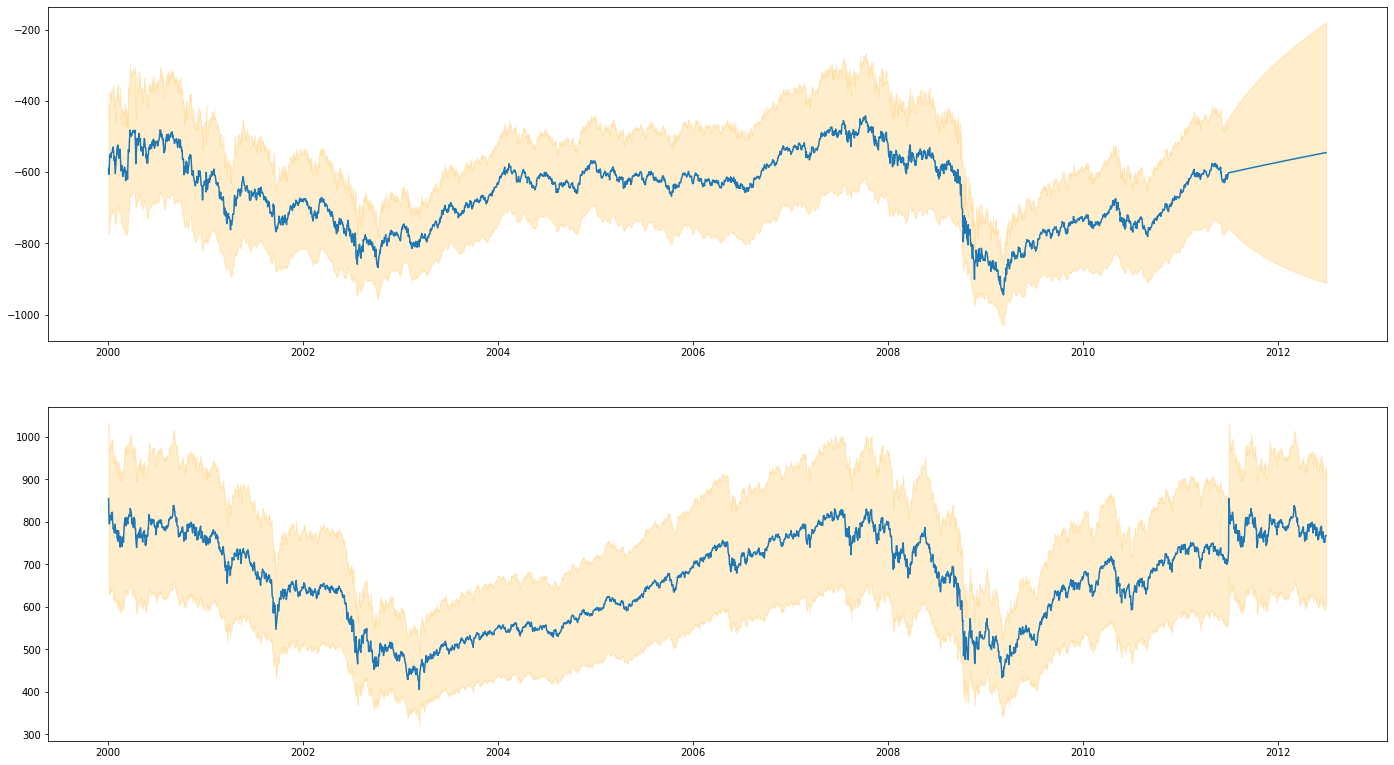

In [18]:
component_dists = sts.decompose_by_component(
    model,
    observed_time_series=training_data.values,
    parameter_samples=samples)

forecast_component_dists = sts.decompose_forecast_by_component(
    model,
    forecast_dist=findata_forecast_dist,
    parameter_samples=samples)

component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

forecast_component_means, forecast_component_stddevs= (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

trend_mean = np.concatenate(
    [component_means['trend/'],
    forecast_component_means['trend/']],
    axis=-1)
trend_stddev = np.concatenate(
    [component_stddevs['trend/'],
    forecast_component_stddevs['trend/']],
    axis=-1)
regression_mean = np.concatenate(
    [component_means['LinearRegression/'],
    forecast_component_means['LinearRegression/']],
    axis=-1)
regression_stddev = np.concatenate(
    [component_stddevs['LinearRegression/'],
    forecast_component_stddevs['LinearRegression/']],
    axis=-1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(48/2,27/2))
ax1.plot(
    dates[all_dates].values,
    trend_mean,
)
ax1.fill_between(
    dates[all_dates],
    trend_mean-2*trend_stddev,
    trend_mean+2*trend_stddev,
    color='Orange',
    alpha=0.2)
ax2.plot(
    dates[all_dates].values,
    regression_mean,
)
ax2.fill_between(
    dates[all_dates],
    regression_mean-2*regression_stddev,
    regression_mean+2*regression_stddev,
    color='Orange',
    alpha=0.2)
plt.show()